原始网络的最短路径和: 21863830.819518004
原始网络的边的总长度: 4908.4204630793365
原始网络的适应值: 21868739.23998108


Population=100:   0%|          | 0/10 [00:00<?, ?it/s]

最终网络的最短路径和: 21858368.167913724
最终网络的边的总长度: 4900.200358738075


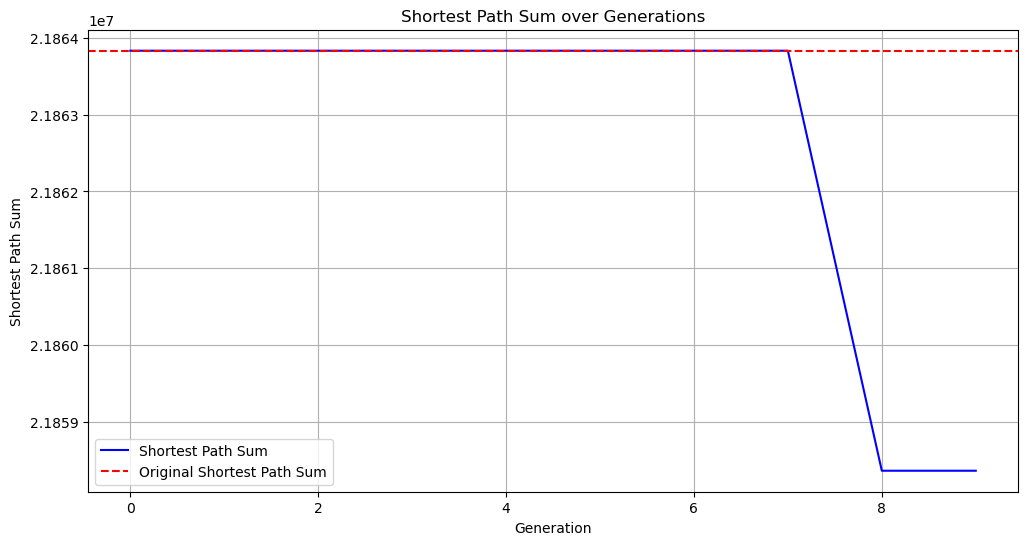

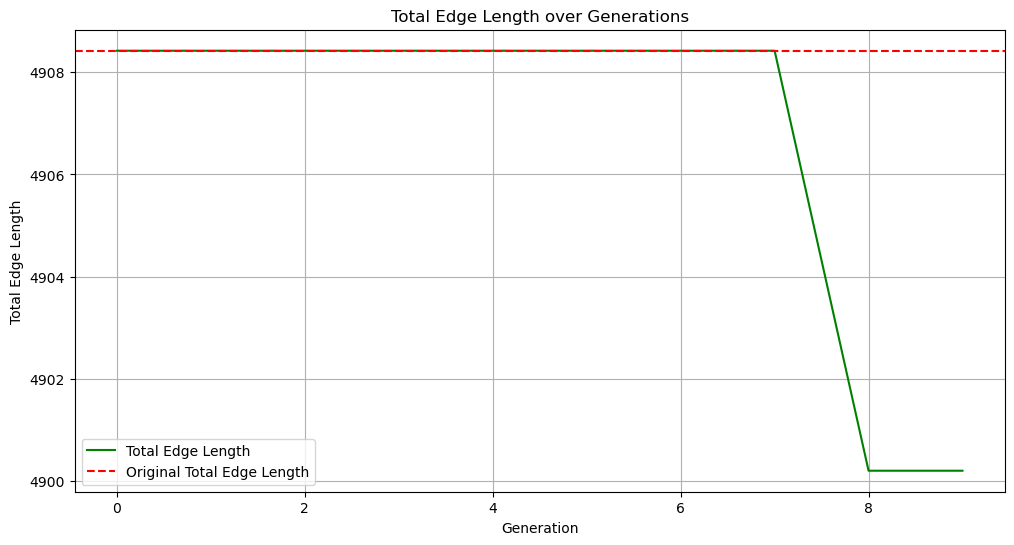

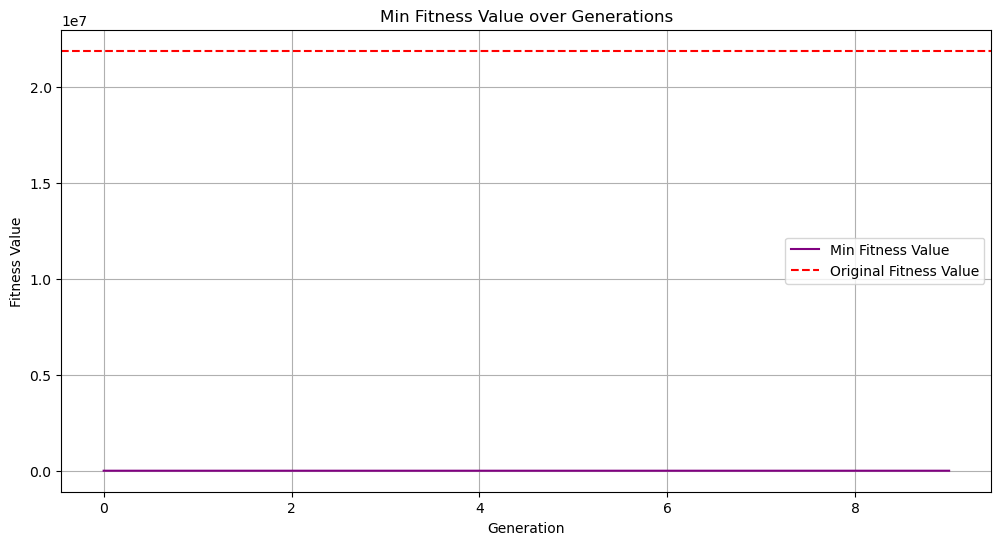

Completed: Pop=100, Select=0.3333333333333333, Mutate=0.3 - Final Fitness=9805.193197332483


In [15]:
import numpy as np
from graph_tool.all import shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm
import python_codes.newga_utils_2 as ga  # 调整后的导入路径
from python_codes.files_operators import save_files


# 读取图和位置信息 
filename1 = "fukuoka_ascend_484_gg"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 计算原始网络的边的总长度
original_total_edge_length = np.sum([edge_weights[edge] for edge in read_graph.edges()])
print(f"原始网络的边的总长度: {original_total_edge_length}")

# 计算原始网络的适应值
original_fitness_value = original_network_value + original_total_edge_length
print(f"原始网络的适应值: {original_fitness_value}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights, original_shortest_path_sum=original_network_value, original_total_edge_length=original_total_edge_length)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程，记录最小适应度值
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)  # 创建 Hall of Fame 用于保存最优个体
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    # 用于记录每代最优个体的指标
    shortest_path_sums = []
    total_edge_lengths = []
    min_fitness_values = []

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        # 更新种群
        pop[:] = selected + offspring
        # 评估适应度
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 更新 Hall of Fame
        hof.update(pop)

        # 获取当前代的最优个体
        best_ind = hof[0]
        best_graph, best_edge_weights = ga.individual_to_graph(best_ind, read_graph.num_vertices(), read_pos)

        # 计算最优个体的最短路径和与边总长度
        dist_matrix = shortest_distance(best_graph, weights=best_edge_weights).get_2d_array(range(best_graph.num_vertices()))
        shortest_path_sum = np.sum(dist_matrix[dist_matrix != np.inf])
        total_edge_length = np.sum([best_edge_weights[edge] for edge in best_graph.edges()])

        shortest_path_sums.append(shortest_path_sum)
        total_edge_lengths.append(total_edge_length)

        # 记录当前代的最优适应度值
        valid_individuals = [ind for ind in pop if ind.fitness.values[0] != float('inf')]
        if valid_individuals:
            min_fitness = np.min([ind.fitness.values[0] for ind in valid_individuals])
        else:
            min_fitness = float('inf')

        min_fitness_values.append(min_fitness)
        logbook.record(gen=gen, min=min_fitness)
        pbar.update(1)

    # 返回 logbook 和记录的指标
    return logbook, hof, shortest_path_sums, total_edge_lengths, min_fitness_values


def plot_results(shortest_path_sums, total_edge_lengths, min_fitness_values, original_network_value, original_total_edge_length, filename, final_shortest_path_sum, final_total_edge_length):
    generations = list(range(len(shortest_path_sums)))
    
    # 打印最终网络的最短路径和与边的总长度
    print(f"最终网络的最短路径和: {final_shortest_path_sum}")
    print(f"最终网络的边的总长度: {final_total_edge_length}")
    
    # 绘制最短路径和的变化
    plt.figure(figsize=(12, 6))
    plt.plot(generations, shortest_path_sums, label="Shortest Path Sum", color="blue")
    plt.axhline(y=original_network_value, color="red", linestyle="--", label="Original Shortest Path Sum")
    plt.xlabel("Generation")
    plt.ylabel("Shortest Path Sum")
    plt.title("Shortest Path Sum over Generations")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./output3/{filename}_shortest_path_sum.png")
    plt.show()

    # 绘制边总长度的变化
    plt.figure(figsize=(12, 6))
    plt.plot(generations, total_edge_lengths, label="Total Edge Length", color="green")
    plt.axhline(y=original_total_edge_length, color="red", linestyle="--", label="Original Total Edge Length")
    plt.xlabel("Generation")
    plt.ylabel("Total Edge Length")
    plt.title("Total Edge Length over Generations")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./output3/{filename}_total_edge_length.png")
    plt.show()

    # 绘制适应值最小值的变化
    plt.figure(figsize=(12, 6))
    plt.plot(generations, min_fitness_values, label="Min Fitness Value", color="purple")
    plt.axhline(y=original_network_value, color="red", linestyle="--", label="Original Fitness Value")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value")
    plt.title("Min Fitness Value over Generations")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./output3/{filename}_min_fitness.png")
    plt.show()


# 参数配置
num_generations = 10
population_sizes = [100]
selection_ratios = [1 / 3]
mutation_probs = [0.3]
progress_bars = {
    pop_size: tqdm(total=1 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

for future in as_completed(future_to_params):
    selection_ratio, mutpb = future_to_params[future]
    try:
        logbook, hof, shortest_path_sums, total_edge_lengths, min_fitness_values = future.result()
        all_logbooks.append((logbook, selection_ratio, mutpb))

        # 计算最终网络的最短路径和与边的总长度
        final_best_ind = hof[0]
        final_best_graph, final_best_edge_weights = ga.individual_to_graph(final_best_ind, read_graph.num_vertices(), read_pos)

        # 保存最终网络图像
        output_path = f"./output3/{filename1}_final_network.png"
        graph_draw(
            final_best_graph,
            pos=read_pos,
            edge_pen_width=2.0,
            edge_color="blue",
            vertex_fill_color="red",
            vertex_size=10,
            output_size=(1000, 1000),
            output=output_path
        )

        # 保存最终网络为 .net 文件
        output_net_path = f"./output3/{filename1}_final_network.net"
        save_files(output_net_path, final_best_graph, read_pos, position_flag=True)

        dist_matrix = shortest_distance(final_best_graph, weights=final_best_edge_weights).get_2d_array(range(final_best_graph.num_vertices()))
        final_shortest_path_sum = np.sum(dist_matrix[dist_matrix != np.inf])
        final_total_edge_length = np.sum([final_best_edge_weights[edge] for edge in final_best_graph.edges()])

        # 绘制结果图
        plot_results(shortest_path_sums, total_edge_lengths, min_fitness_values, original_network_value, original_total_edge_length, filename1, final_shortest_path_sum, final_total_edge_length)

        print(
            f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={logbook[-1]["min"]}')

    except Exception as ex:
        print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')
        import traceback
        traceback.print_exc()

